In [1]:
import time

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import pytorch_lightning as pl

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, \
    f1_score, accuracy_score, precision_score, recall_score

from cancernet.arch import InteractionNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet

## Load dataset

In [2]:
dataset = PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    #files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))

Ensure consistent and reproducible train/validation/test split.

In [3]:
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)

In [4]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15080, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [5]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

## Train

Set up hyperparameters and random seed.

In [6]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 200
batch_size = 10
lr = 0.001

Global seed set to 42


Prepare data.

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Visualize the connectivity of the graph.

Text(0, 0.5, 'Frequency')

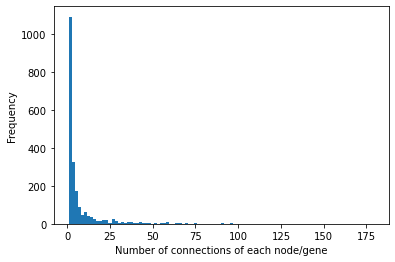

In [8]:
# XXX this should be somewhere else
data = next(iter(train_loader))
edge_indices = data[0].edge_index.cpu().numpy()
edge_counter = 1
connections = []
gene = edge_indices[1][0]
for aa in range(len(edge_indices[0])):
    if gene == edge_indices[1][aa]:
        edge_counter += 1
    else:
        gene = edge_indices[1][aa]
        connections.append(edge_counter)
        edge_counter = 1
    # print(edge_indices[1][aa])
    
plt.hist(connections, bins=100)
plt.xlabel("Number of connections of each node/gene")
plt.ylabel("Frequency")

Create and train model.

In [9]:
t0 = time.time()

model = InteractionNet()
logger = InMemoryLogger()

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | meta_layer | MetaLayer | 102 K 
-----------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.408     Total estimated model params size (MB)
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training took 315.3 seconds.


Visualize training trajectory.

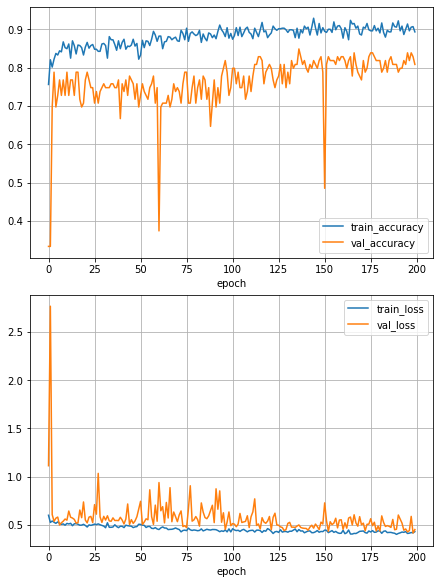

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

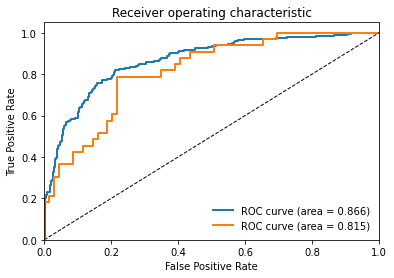

In [11]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
ax.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [12]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print('accuracy', accuracy_score(ys, outs[:, 1] > 0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1] > 0.5))
print('precision', precision_score(ys, outs[:, 1] > 0.5))
print('recall', recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.81
auc 0.9086386250565355
aupr 0.8409160392615178
f1 0.6779661016949152
precision 0.7692307692307693
recall 0.6060606060606061
